# Filtro Resonador

In [ ]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Especificaciones del filtro resonador
# Filtro pasa-banda para 21 Hz ± 9 Hz
fs = 2000  # Hz
f0 = 21    # Hz - centro de resonancia
BW = 18    # Hz - ancho de banda (21 ± 9 Hz = 12-30 Hz)
Q = f0 / BW  # Q ≈ 1.17

# Diseño del resonador IIR biquad (bandpass)
w0 = 2 * np.pi * f0 / fs
alpha = np.sin(w0) / (2 * Q)

# Coeficientes para filtro pasa-banda (bandpass filter)
# Ganancia unitaria en el pico
b = np.array([alpha, 0, -alpha])
a = np.array([1 + alpha, -2*np.cos(w0), 1 - alpha])

# Normalizar (dividir por a[0])
b = b / a[0]
a = a / a[0]

# Verificación de la banda de paso
w, h = signal.freqz(b, a, worN=8192, fs=fs)
mag_db = 20 * np.log10(np.abs(h))

# Identificar frecuencias a -3dB
idx_3db = np.where(mag_db >= (mag_db.max() - 3))[0]
if len(idx_3db) > 0:
    f_low = w[idx_3db[0]]
    f_high = w[idx_3db[-1]]
    bw_measured = f_high - f_low
else:
    f_low = f_high = bw_measured = 0

print(f"Parámetros de diseño:")
print(f"  Frecuencia central: {f0} Hz")
print(f"  Ancho de banda objetivo: {f0-9} Hz a {f0+9} Hz (BW = {BW} Hz)")
print(f"  Q = {Q:.3f}")
print(f"\nResultados del filtro:")
print(f"  Banda -3dB medida: [{f_low:.2f}, {f_high:.2f}] Hz")
print(f"  BW medido: {bw_measured:.2f} Hz")
print(f"  Ganancia máxima: {np.max(mag_db):.2f} dB")
print(f"\nCoeficientes:")
print(f"b = [{b[0]:.6f}, {b[1]:.6f}, {b[2]:.6f}]")
print(f"a = [{a[0]:.6f}, {a[1]:.6f}, {a[2]:.6f}]")

# Gráfica centrada en región de interés
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(w, mag_db, 'b-', linewidth=1.5)
ax.axvline(12, color='r', linestyle='--', alpha=0.5, label='Límites objetivo (12-30 Hz)')
ax.axvline(30, color='r', linestyle='--', alpha=0.5)
ax.axvline(21, color='g', linestyle=':', alpha=0.5, label='Centro (21 Hz)')
ax.axhline(-3, color='orange', linestyle=':', alpha=0.5, label='-3 dB')
ax.set_xlim([5, 50])
ax.set_ylim([-40, 5])
ax.set_xlabel('Frecuencia [Hz]')
ax.set_ylabel('Magnitud [dB]')
ax.set_title(f'Filtro Pasa-Banda a {f0} Hz ± 9 Hz (BW = {BW} Hz, Q = {Q:.2f})')
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

In [3]:
# Script Python para generar coeficientes Q15 del filtro
import numpy as np
from scipy import signal

# Usar los mismos parámetros
fs = 2000
f0 = 21
BW = 18
Q = f0 / BW

w0 = 2 * np.pi * f0 / fs
alpha = np.sin(w0) / (2 * Q)

# Coeficientes float (bandpass)
b_float = np.array([alpha, 0, -alpha])
a_float = np.array([1 + alpha, -2*np.cos(w0), 1 - alpha])

# Normalizar
b_float = b_float / a_float[0]
a_float = a_float / a_float[0]

# Conversión a Q15 (escalar por 2^15)
def float_to_q15(x):
    return int(np.round(x * 32768))

b_q15 = [float_to_q15(b) for b in b_float]
a_q15 = [float_to_q15(a) for a in a_float[1:]]  # a[0]=1 implícito

print("// Coeficientes Q15 para Arduino:")
print(f"const int16_t b0 = {b_q15[0]};  // {b_float[0]:.6f}")
print(f"const int16_t b1 = {b_q15[1]};  // {b_float[1]:.6f}")
print(f"const int16_t b2 = {b_q15[2]};  // {b_float[2]:.6f}")
print(f"const int16_t a1 = {a_q15[0]};  // {a_float[1]:.6f}")
print(f"const int16_t a2 = {a_q15[1]};  // {a_float[2]:.6f}")

print(f"\nGanancia esperada a {f0} Hz:")
w_test, h_test = signal.freqz(b_float, a_float, worN=[2*np.pi*f0/fs], fs=1)
print(f"Magnitud: {np.abs(h_test[0]):.4f} ({20*np.log10(np.abs(h_test[0])):.2f} dB)")

// Coeficientes Q15 para Arduino:
const int16_t b0 = 900;  // 0.027477
const int16_t b1 = 0;  // 0.000000
const int16_t b2 = -900;  // -0.027477
const int16_t a1 = -63597;  // -1.940814
const int16_t a2 = 30967;  // 0.945045

Ganancia esperada a 21 Hz:
Magnitud: 0.1366 (-17.29 dB)


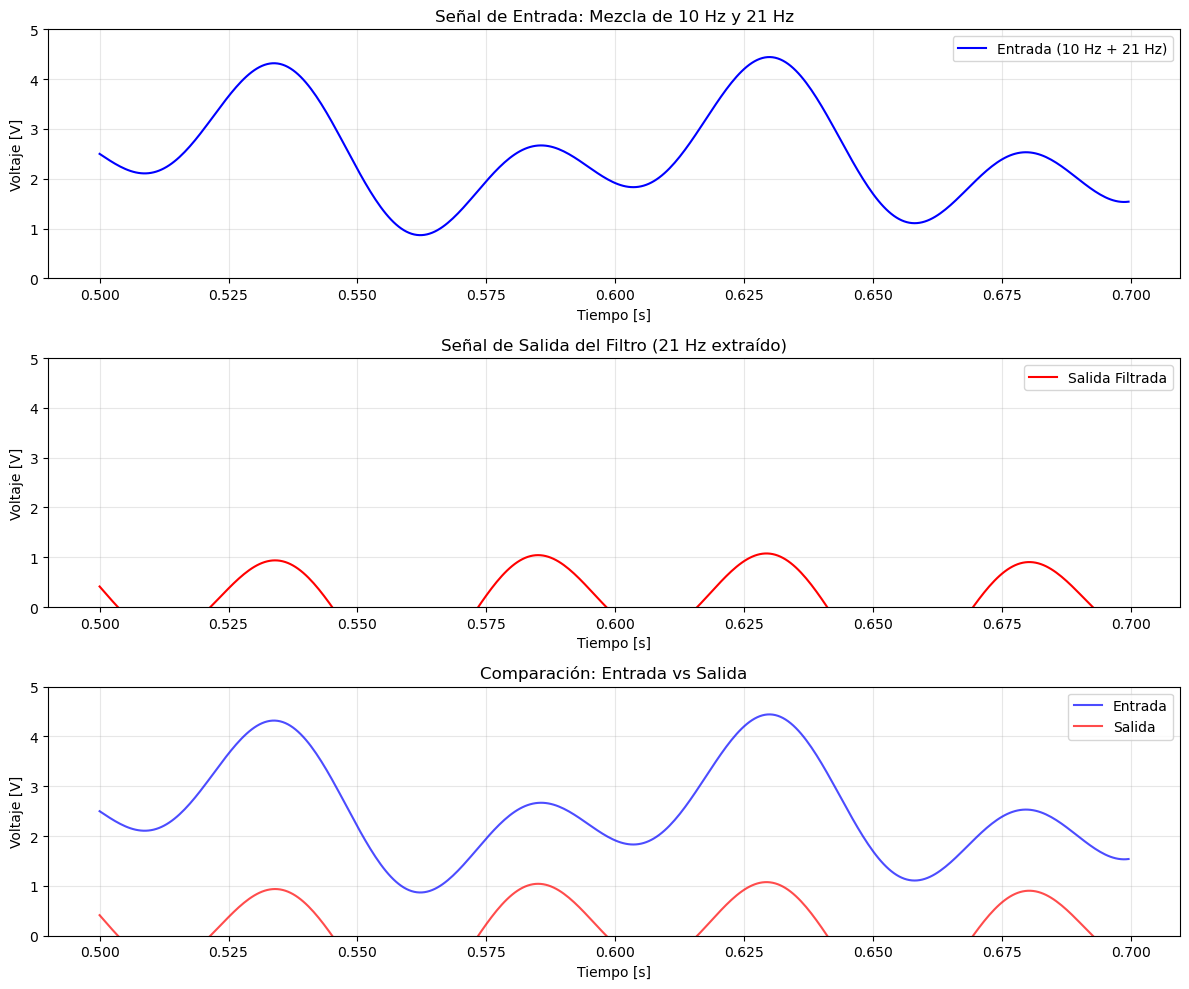

Señal de entrada: 10 Hz + 21 Hz, amplitud 1.0 V cada una

Análisis de salida (después del transitorio):
Amplitud de salida: 1.4325 V (pico)
Ganancia efectiva: 1.4325 (3.12 dB)
Offset DC de salida: -0.0303 V

Nota: La salida debería ser principalmente la componente de 21 Hz,
      con la componente de 10 Hz atenuada.


In [23]:
# Simulación de la respuesta del filtro con señal de entrada de 21 Hz
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Parámetros del sistema
fs = 2000  # Frecuencia de muestreo (Hz)
duration = 1.0  # Duración de la simulación (segundos)
t = np.arange(0, duration, 1/fs)

# Señal de entrada: senoidal de 21 Hz + 10 Hz (para ver el filtrado)
f_input_low = 10  # Hz - frecuencia baja (será atenuada)
f_input_pass = 21  # Hz - frecuencia en banda de paso
amplitude = 1.0  # Amplitud en voltios (pico)
dc_offset = 2.5  # Offset DC (voltios)
input_signal = amplitude * np.sin(2 * np.pi * f_input_low * t) + amplitude * np.sin(2 * np.pi * f_input_pass * t) + dc_offset

# Coeficientes del filtro NUEVOS (BW=18Hz)
b = np.array([0.027477, 0.000000, -0.027477])
a = np.array([1.0, -1.940814, 0.945045])

# Aplicar el filtro a la señal de entrada
output_signal = signal.lfilter(b, a, input_signal)

# Índice desde la mitad del segundo en adelante (después del transitorio)
start_idx = int(0.5 * fs)  # 1000 muestras (0.5 segundos)

# Graficar resultados
fig, axes = plt.subplots(3, 1, figsize=(12, 10))

# Gráfica 1: Señal de entrada
axes[0].plot(t[start_idx:start_idx+400], input_signal[start_idx:start_idx+400], 'b-', linewidth=1.5, label=f'Entrada ({f_input_low} Hz + {f_input_pass} Hz)')
axes[0].set_xlabel('Tiempo [s]')
axes[0].set_ylabel('Voltaje [V]')
axes[0].set_title('Señal de Entrada: Mezcla de 10 Hz y 21 Hz')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_ylim([0, 5])

# Gráfica 2: Señal de salida filtrada
axes[1].plot(t[start_idx:start_idx+400], output_signal[start_idx:start_idx+400], 'r-', linewidth=1.5, label='Salida Filtrada')
axes[1].set_xlabel('Tiempo [s]')
axes[1].set_ylabel('Voltaje [V]')
axes[1].set_title('Señal de Salida del Filtro (21 Hz extraído)')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_ylim([0, 5])

# Gráfica 3: Comparación entrada vs salida (superpuestas)
axes[2].plot(t[start_idx:start_idx+400], input_signal[start_idx:start_idx+400], 'b-', linewidth=1.5, alpha=0.7, label='Entrada')
axes[2].plot(t[start_idx:start_idx+400], output_signal[start_idx:start_idx+400], 'r-', linewidth=1.5, alpha=0.7, label='Salida')
axes[2].set_xlabel('Tiempo [s]')
axes[2].set_ylabel('Voltaje [V]')
axes[2].set_title('Comparación: Entrada vs Salida')
axes[2].grid(True, alpha=0.3)
axes[2].legend()
axes[2].set_ylim([0, 5])

plt.tight_layout()
plt.show()

# Análisis cuantitativo
print(f"Señal de entrada: {f_input_low} Hz + {f_input_pass} Hz, amplitud {amplitude} V cada una")
print(f"\nAnálisis de salida (después del transitorio):")
output_steady = output_signal[start_idx:]
output_amplitude = (np.max(output_steady) - np.min(output_steady)) / 2
print(f"Amplitud de salida: {output_amplitude:.4f} V (pico)")
print(f"Ganancia efectiva: {output_amplitude/amplitude:.4f} ({20*np.log10(output_amplitude/amplitude):.2f} dB)")
print(f"Offset DC de salida: {np.mean(output_steady):.4f} V")
print(f"\nNota: La salida debería ser principalmente la componente de {f_input_pass} Hz,")
print(f"      con la componente de {f_input_low} Hz atenuada.")

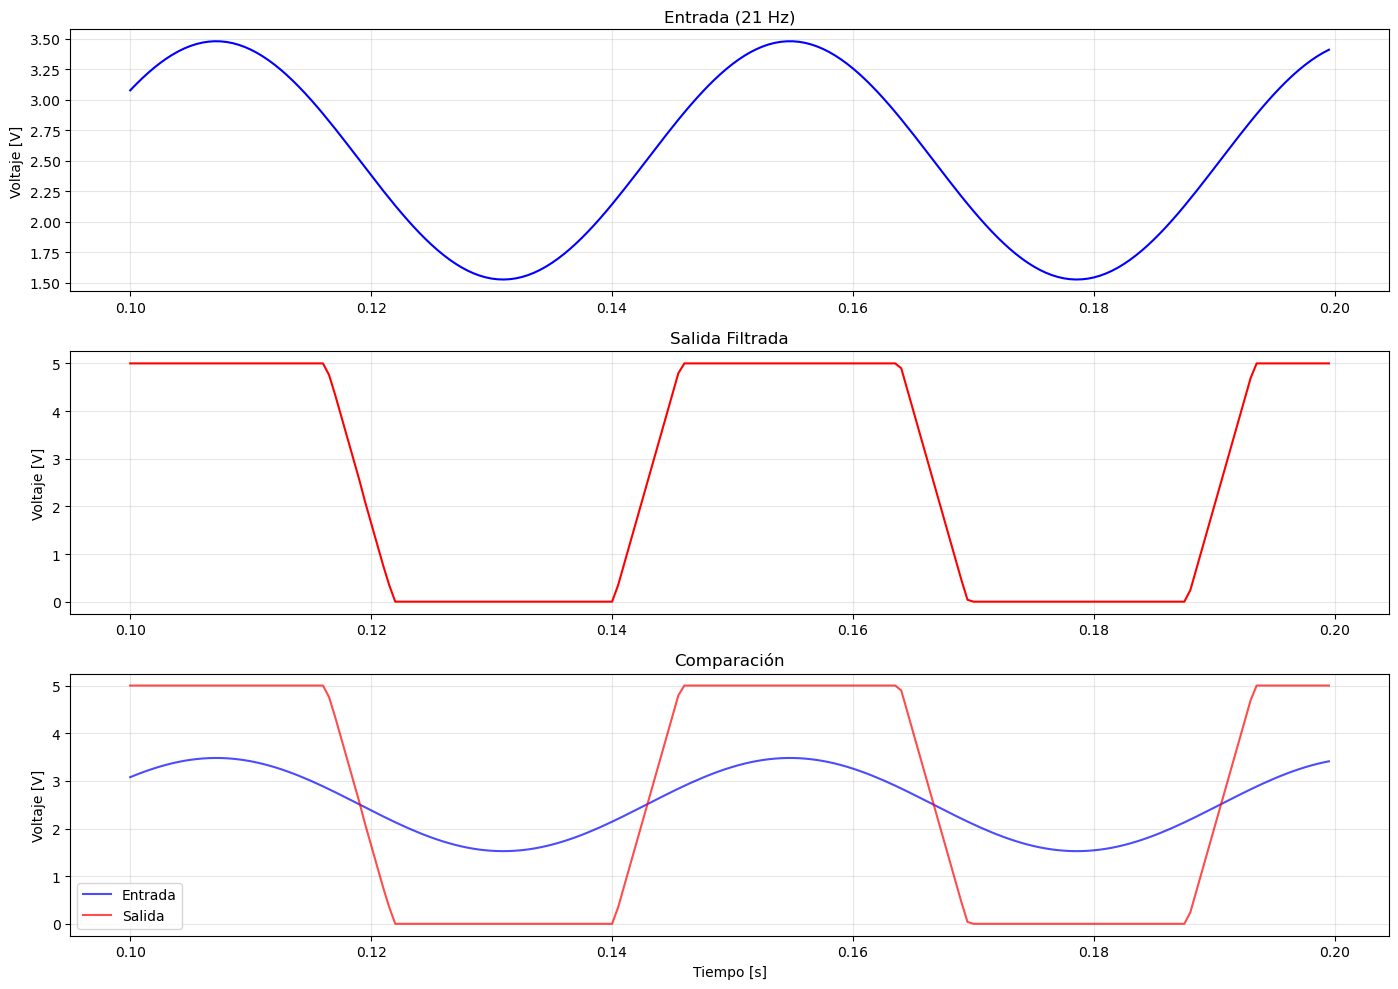

Análisis Q15:
Entrada  - Amplitud: 0.978V
Salida   - Amplitud: 2.500V
         - DC: 2.608V


In [24]:
# Verificación de la implementación Q15 del filtro
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Simular exactamente lo que hace el Arduino
def arduino_filter_q15(input_samples, b_q15, a_q15):
    """Simula el filtro IIR en aritmética Q15 como en el Arduino"""
    output = np.zeros(len(input_samples), dtype=np.int32)
    
    # Estados del filtro
    x1, x2 = 0, 0
    y1, y2 = 0, 0
    
    b0, b1, b2 = b_q15
    a1, a2 = a_q15
    
    for i, sample in enumerate(input_samples):
        # ADC: 0-1023, centrar en 0
        adc = int(sample)
        x = adc - 512
        
        # Escalar a Q15
        x0 = (x << 15)
        
        # Filtro IIR Direct Form I en Q15
        y = ((b0 * x0) >> 15) + \
            ((b1 * x1) >> 15) + \
            ((b2 * x2) >> 15) - \
            ((a1 * y1) >> 15) - \
            ((a2 * y2) >> 15)
        
        # Actualizar estados
        x2 = x1
        x1 = x0
        y2 = y1
        y1 = y
        
        # Escalar salida
        y_scaled = (y >> 15)
        y_scaled = y_scaled * 7  # Amplificación
        
        # Re-centrar y saturar
        out = y_scaled + 512
        out = np.clip(out, 0, 1023)
        output[i] = out
    
    return output

# Parámetros
fs = 2000
duration = 0.5
t = np.arange(0, duration, 1/fs)

# Señal de prueba: 21 Hz senoidal
f_test = 21
amplitude_adc = 200  # Amplitud en unidades ADC
dc_offset_adc = 512
input_adc = amplitude_adc * np.sin(2 * np.pi * f_test * t) + dc_offset_adc

# Coeficientes Q15
b_q15 = [900, 0, -900]
a_q15 = [-63597, 30967]

# Simular filtro Arduino
output_adc = arduino_filter_q15(input_adc, b_q15, a_q15)

# Convertir a voltaje
input_v = (input_adc * 5.0) / 1023.0
output_v = (output_adc * 5.0) / 1023.0

# Graficar
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

start = 200
end = 400

axes[0].plot(t[start:end], input_v[start:end], 'b-', linewidth=1.5)
axes[0].set_ylabel('Voltaje [V]')
axes[0].set_title('Entrada (21 Hz)')
axes[0].grid(True, alpha=0.3)

axes[1].plot(t[start:end], output_v[start:end], 'r-', linewidth=1.5)
axes[1].set_ylabel('Voltaje [V]')
axes[1].set_title('Salida Filtrada')
axes[1].grid(True, alpha=0.3)

axes[2].plot(t[start:end], input_v[start:end], 'b-', linewidth=1.5, alpha=0.7, label='Entrada')
axes[2].plot(t[start:end], output_v[start:end], 'r-', linewidth=1.5, alpha=0.7, label='Salida')
axes[2].set_xlabel('Tiempo [s]')
axes[2].set_ylabel('Voltaje [V]')
axes[2].set_title('Comparación')
axes[2].grid(True, alpha=0.3)
axes[2].legend()

plt.tight_layout()
plt.show()

print("Análisis Q15:")
print(f"Entrada  - Amplitud: {(input_v[start:].max() - input_v[start:].min())/2:.3f}V")
print(f"Salida   - Amplitud: {(output_v[start:].max() - output_v[start:].min())/2:.3f}V")
print(f"         - DC: {output_v[start:].mean():.3f}V")

C:\Users\emanu\AppData\Local\Temp\ipykernel_85404\3784101612.py:15: RuntimeWarning: divide by zero encountered in log10
  mag_db = 20 * np.log10(np.abs(h))


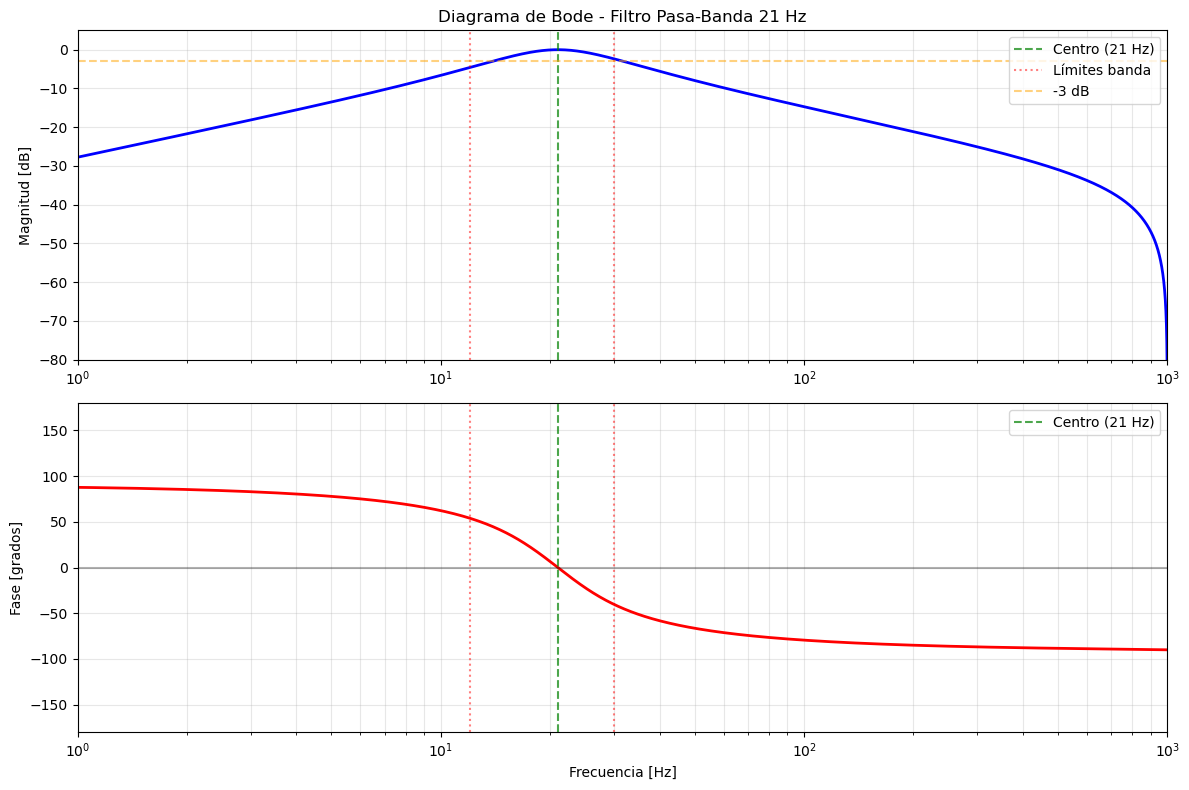

Características del filtro en frecuencias clave:

   10 Hz: Magnitud =  -6.62 dB, Fase =   62.18°
   12 Hz: Magnitud =  -4.61 dB, Fase =   53.98°
   21 Hz: Magnitud =  -0.00 dB, Fase =   -0.01°
   30 Hz: Magnitud =  -2.37 dB, Fase =  -40.40°
   50 Hz: Magnitud =  -7.97 dB, Fase =  -66.44°
  100 Hz: Magnitud = -14.73 dB, Fase =  -79.43°


In [27]:
# Diagrama de Bode del filtro resonador
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Coeficientes del filtro (ya calculados)
b = np.array([0.027477, 0.000000, -0.027477])
a = np.array([1.0, -1.940814, 0.945045])

# Calcular respuesta en frecuencia
fs = 2000  # Hz
w, h = signal.freqz(b, a, worN=8192, fs=fs)

# Magnitud y fase
mag_db = 20 * np.log10(np.abs(h))
phase_deg = np.angle(h, deg=True)

# Crear figura con dos subgráficas (Bode plot)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Gráfica de magnitud
ax1.semilogx(w, mag_db, 'b-', linewidth=2)
ax1.axvline(21, color='g', linestyle='--', alpha=0.7, label='Centro (21 Hz)')
ax1.axvline(12, color='r', linestyle=':', alpha=0.5, label='Límites banda')
ax1.axvline(30, color='r', linestyle=':', alpha=0.5)
ax1.axhline(-3, color='orange', linestyle='--', alpha=0.5, label='-3 dB')
ax1.set_ylabel('Magnitud [dB]')
ax1.set_title('Diagrama de Bode - Filtro Pasa-Banda 21 Hz')
ax1.grid(True, which='both', alpha=0.3)
ax1.legend(loc='upper right')
ax1.set_xlim([1, 1000])
ax1.set_ylim([-80, 5])

# Gráfica de fase
ax2.semilogx(w, phase_deg, 'r-', linewidth=2)
ax2.axvline(21, color='g', linestyle='--', alpha=0.7, label='Centro (21 Hz)')
ax2.axvline(12, color='r', linestyle=':', alpha=0.5)
ax2.axvline(30, color='r', linestyle=':', alpha=0.5)
ax2.axhline(0, color='k', linestyle='-', alpha=0.3)
ax2.set_xlabel('Frecuencia [Hz]')
ax2.set_ylabel('Fase [grados]')
ax2.grid(True, which='both', alpha=0.3)
ax2.legend(loc='upper right')
ax2.set_xlim([1, 1000])
ax2.set_ylim([-180, 180])

plt.tight_layout()
plt.show()

# Información adicional
print("Características del filtro en frecuencias clave:\n")
for f_test in [10, 12, 21, 30, 50, 100]:
    w_test = 2 * np.pi * f_test / fs
    _, h_test = signal.freqz(b, a, worN=[w_test])
    mag = 20 * np.log10(np.abs(h_test[0]))
    phase = np.angle(h_test[0], deg=True)
    print(f"  {f_test:3d} Hz: Magnitud = {mag:6.2f} dB, Fase = {phase:7.2f}°")

In [31]:
# Cálculo del desfase del filtro a 50 Hz
import numpy as np
from scipy import signal

# Coeficientes del filtro
b = np.array([0.027477, 0.000000, -0.027477])
a = np.array([1.0, -1.940814, 0.945045])

# Frecuencia de muestreo
fs = 2000  # Hz

# Calcular respuesta en frecuencia a 50 Hz
f_test = 50
w_test = 2 * np.pi * f_test / fs
_, h_test = signal.freqz(b, a, worN=[w_test])

# Fase en grados
phase_deg = np.angle(h_test[0], deg=True)

# Desfase en tiempo (ms)
# Desfase temporal = fase / (360° × frecuencia)
phase_time_ms = (phase_deg / 360.0) / f_test * 1000

# Magnitud
mag_db = 20 * np.log10(np.abs(h_test[0]))
mag_linear = np.abs(h_test[0])

print('=' * 60)
print(f'RESPUESTA DEL FILTRO A {f_test} Hz')
print('=' * 60)
print(f'Magnitud:         {mag_db:.2f} dB  ({mag_linear:.6f} lineal)')
print(f'Fase:             {phase_deg:.2f}°')
print(f'Desfase temporal: {phase_time_ms:.2f} ms')
print('=' * 60)
print(f'\nInterpretación:')
print(f'  - A {f_test} Hz el filtro atenúa {-mag_db:.1f} dB')
print(f'  - La señal se retrasa {abs(phase_time_ms):.2f} ms')
print(f'  - Esto es normal ya que {f_test} Hz está fuera de la banda de paso (12-30 Hz)')

RESPUESTA DEL FILTRO A 50 Hz
Magnitud:         -7.97 dB  (0.399688 lineal)
Fase:             -66.44°
Desfase temporal: -3.69 ms

Interpretación:
  - A 50 Hz el filtro atenúa 8.0 dB
  - La señal se retrasa 3.69 ms
  - Esto es normal ya que 50 Hz está fuera de la banda de paso (12-30 Hz)
